### Run cell block below only once when setting up the dataset

In [1]:
import kagglehub
import os
import shutil

# Download latest version
path = kagglehub.dataset_download("sagarkarar/nonface-and-face-dataset")

print("Path to dataset files:", path)

# Get current working directory
current_directory = os.getcwd()

# Create two subfolders in the current directory
human_folder = os.path.join(current_directory, "dataset", "faces")
other_folder = os.path.join(current_directory, "dataset", "other")

# Create the subfolders if they don't exist
os.makedirs(human_folder, exist_ok=True)
os.makedirs(other_folder, exist_ok=True)

# Iterate over all files in the downloaded dataset directory
path = os.path.join(path, 'Dataset')
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)

    # Skip directories
    if os.path.isdir(file_path):
        continue

    # Check if 'Human' is in the filename
    if 'Human' in filename:
        # faces
        shutil.copy(file_path, os.path.join(human_folder, filename))
    else:
        # non faces
        shutil.copy(file_path, os.path.join(other_folder, filename))

print("Files have been copied to the appropriate subfolders in the current directory.")

100%|██████████| 836M/836M [01:21<00:00, 10.8MB/s] 

Extracting files...


Path to dataset files: /Users/mathewmaradin/.cache/kagglehub/datasets/sagarkarar/nonface-and-face-dataset/versions/1
Files have been copied to the appropriate subfolders in the current directory.


In [ ]:
%pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.5 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F

IMG_SIZE = 60
# transformation for pre-processing images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # grayscale
    transforms.ToTensor(),  # make tensor
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # make all images the same size
    # transforms.Normalize(mean=[0.5], std=[0.5])  # normalize
])

# faces have label 0, other has label 1 (two classes)
dataset = datasets.ImageFolder('dataset', transform=transform)


AttributeError: module 'torch' has no attribute 'SymInt'

In [32]:
N = len(dataset)
PERCENT_TRAIN = 0.8
num_train = int(PERCENT_TRAIN*N)
num_test = N - num_train

print(f'Total images in dataset: {N} | Images for training: {num_train} | Images for Testing: {num_test}')

# randomly choose num_train elements for training and 
# a separate group of num_test elements for testing, without any overlap
order = np.random.permutation(N)
X_train = torch.utils.data.Subset(dataset, order[:num_train])
X_test = torch.utils.data.Subset(dataset, order[num_train:]) 

train_loader = torch.utils.data.DataLoader(X_train, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=500, shuffle=True)

Total images in dataset: 2648 | Images for training: 2118 | Images for Testing: 530


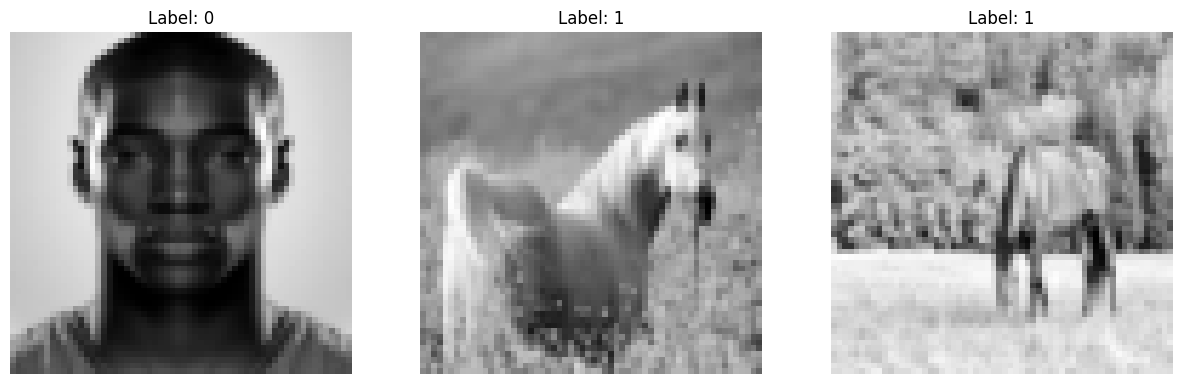

In [33]:
import matplotlib.pyplot as plt
import torch
from PIL import Image

# Create a function to visualize the images and their labels
def plot_images(dataset, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for j in range(num_images):
        i = 1000 + j
        image, label = dataset[-j]
        
        # Convert tensor to numpy array for plotting
        image = image.numpy().transpose(1, 2, 0)
        
        # Plot the image
        axes[j].imshow(image, cmap='gray')
        axes[j].set_title(f"Label: {label}")
        axes[j].axis('off')  # Hide axes
    
    plt.show()

# Assuming 'dataset' is the instance of your CustomDataset
plot_images(dataset)

In [37]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 =  nn.Linear(20 * 12 * 12, 50)  # Dynamically calculate later
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Conv + ReLU + Pooling
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Conv + ReLU + Pooling
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Log-softmax for binary classification

network = Net()

In [39]:
# create the learning rule
optimizer = torch.optim.SGD(network.parameters(),
                            lr=0.1,   # learning rate
                            momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

# Training Function
def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule

            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
            print(f'Iteration {i+1}')
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)

    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)

In [40]:
# Train for 10 iterations
for i in range(10):
    continue_training()

Iteration 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Iteration 1
Iteration 1
Iteration 1


KeyboardInterrupt: 